## Import Packages

In [1]:
import numpy as np
import cv2
import glob
import os
import re
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Returns HOG features and/or visualization. 
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:
        img = mpimg.imread(file)
        features.append(single_img_features(img, color_space=color_space, spatial_size=spatial_size, 
                                           hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
    return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            #hog_features = np.ravel(hog_features)
            #hog_features = np.concatenate(hog_features) #15:08
            
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


## 1. Histogram of Oriented Gradients

### 1.1 Explore Car and Non-Car Datasets

Examine a few files from the car and non-car dataset. Note that GTI dataset is timeseries, meaning the files are in sequence batches. Below are examples from the GTI dataset showing the time-series characteristic. 

Number of Car Data from KITTI: 5966
Number of Car Data from GTI: 2826
Total: 8792

Examples below from GTI Car Dataset


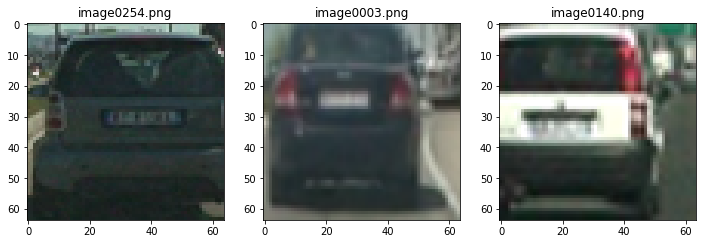

In [4]:
car_files = glob.glob('./vehicles/KITTI*/*.png')
n_KITTI_car_files = len(car_files)
print("Number of Car Data from KITTI:", n_KITTI_car_files)

car_files = glob.glob('./vehicles/GTI*/*.png')
n_GTI_car_files = len(car_files)
print("Number of Car Data from GTI:", n_GTI_car_files)
print("Total:", n_KITTI_car_files + n_GTI_car_files)
print("")
print("Examples below from GTI Car Dataset")
fig = plt.figure(figsize=(12,4))
for i in range(3):  
    plt.subplot(1,3,i+1)
    plt.title(os.path.basename(car_files[i]))
    plt.imshow(mpimg.imread(car_files[i]))


Non vehicle GTI data file names go from image1.png to image3900.png. Due to the alphabetical order the files are read in, this causes image10.png to appear before image2.png. This is not convenient when dealing with time-series data so a function numericalSort is used to sort the data numerically.

Number of Non-Car Data from KITTI: 5068
Number of Non-Car Data from GTI: 3900
Total: 8968

Examples below from GTI Non-Car Dataset


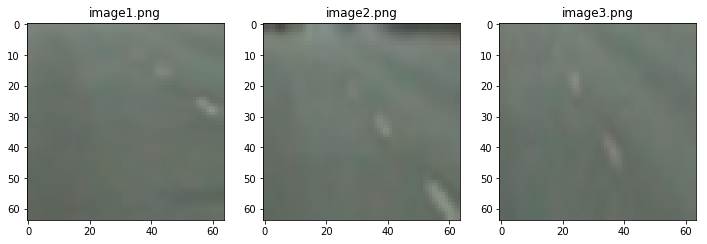

In [5]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    # Sort numerically rather than alphabetically 
    # https://stackoverflow.com/questions/12093940/
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

non_car_files = glob.glob('./non-vehicles/Extras/*.png')
n_KITTI_non_car_files = len(non_car_files)
print("Number of Non-Car Data from KITTI:", n_KITTI_non_car_files)

non_car_files = glob.glob('./non-vehicles/GTI/*.png')
n_GTI_non_car_files = len(non_car_files)
print("Number of Non-Car Data from GTI:", n_GTI_non_car_files)
print("Total:", n_KITTI_non_car_files + n_GTI_non_car_files)

non_car_files = glob.glob('./non-vehicles/GTI/*png')
non_car_files = sorted(non_car_files, key=numericalSort)
print("")
print("Examples below from GTI Non-Car Dataset")

fig = plt.figure(figsize=(12,4))
for i in range(3):  
    plt.subplot(1,3,i+1)
    plt.title(os.path.basename(non_car_files[i]))
    plt.imshow(mpimg.imread(non_car_files[i]))

### 1.2 Read in Dataset and Split into Training and Test Set
Because GTI dataset contains time-series data, I split the data in such a way to avoid the same vehicle or non-vehicle from appearing in the training, validation, test splits. Therefore, I do not randomize the data prior to splitting. This ensures that at most only 1 instance of the same vehicle/non-vehicle may appear across the split data sets.

In [6]:
car_train_files = []
car_test_files = []
non_car_train_files = []
non_car_test_files = []

car_files_dir = []
non_car_files_dir = []

car_files_dir.append('./vehicles/GTI_Far/*.png')
car_files_dir.append('./vehicles/GTI_MiddleClose/*.png')
car_files_dir.append('./vehicles/GTI_Left/*.png')
car_files_dir.append('./vehicles/GTI_Right/*.png')
car_files_dir.append('./vehicles/KITTI_extracted/*.png')
non_car_files_dir.append('./non-vehicles/Extras/*.png')
non_car_files_dir.append('./non-vehicles/GTI/*.png')

for d in car_files_dir:
    car_files = glob.glob(d)
    num_files = len(car_files)
    len1 = int(num_files * 0.8)
    len2 = num_files
    car_train_files.extend(car_files[:len1])
    car_test_files.extend(car_files[len1:len2])
    
for d in non_car_files_dir:
    non_car_files = glob.glob(d)
    non_car_files = sorted(non_car_files, key=numericalSort)
    num_files = len(non_car_files)
    len1 = int(num_files * 0.8)
    len2 = num_files
    non_car_train_files.extend(non_car_files[:len1])
    non_car_test_files.extend(non_car_files[len1:len2])


In [7]:
print('Samples in car training data set:', len(car_train_files))
print('Samples in car test data set:', len(car_test_files))

print('Samples in non-car training data set:', len(non_car_train_files))
print('Samples in non-car test data set:', len(non_car_test_files))

Samples in car training data set: 7032
Samples in car test data set: 1760
Samples in non-car training data set: 7174
Samples in non-car test data set: 1794


### 1.3 Explore Features

In [8]:
# Read in a Car Image to experiment with
car_image = mpimg.imread(car_train_files[0])
non_car_image = mpimg.imread(non_car_train_files[0])

#car_image = mpimg.imread(car_train_files[np.random.randint(0,len(car_train_files))])
#non_car_image = mpimg.imread(non_car_train_files[np.random.randint(0,len(non_car_train_files))])

In [9]:
# Experiment with parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

Orient: 10
pix_per_cell: 8
cell_per_block: 2
Channel 0 of YCrCb


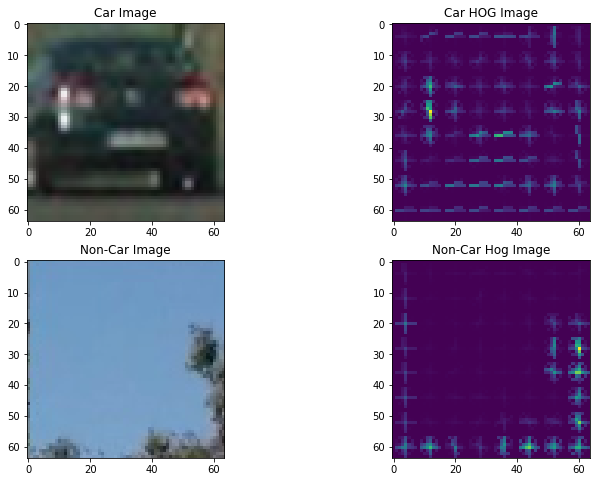

In [10]:
print("Orient:", orient)
print("pix_per_cell:", pix_per_cell)
print("cell_per_block:", cell_per_block)
print("Channel", hog_channel, "of", color_space)

fig = plt.figure(figsize=(12,8))

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                         hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                         spatial_feat=spatial_feat, hist_feat=hist_feat,
                                         hog_feat=hog_feat, vis=True)

plt.subplot(2,2,1)
plt.title('Car Image')
plt.imshow(car_image)
plt.subplot(2,2,2)
plt.title('Car HOG Image')
plt.imshow(car_hog_image)

non_car_features, non_car_hog_image = single_img_features(non_car_image, color_space=color_space, spatial_size=spatial_size,
                                         hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                         spatial_feat=spatial_feat, hist_feat=hist_feat,
                                         hog_feat=hog_feat, vis=True)
plt.subplot(2,2,3)
plt.title('Non-Car Image')
plt.imshow(non_car_image)
plt.subplot(2,2,4)
plt.title('Non-Car Hog Image')
plt.imshow(non_car_hog_image)


In [11]:
## For the training we use ALL. Channel 0 above was only for visualization. 
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

### 1.4 Extract Features

In [12]:
t=time.time()

car_train_features = extract_features(car_train_files, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
#car_valid_features = extract_features(car_valid_files, color_space=color_space, spatial_size=spatial_size,
#                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
#                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
#                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
car_test_features = extract_features(car_test_files, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

non_car_train_features = extract_features(non_car_train_files, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
#non_car_valid_features = extract_features(non_car_valid_files, color_space=color_space, spatial_size=spatial_size,
#                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
#                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
#                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
non_car_test_features = extract_features(non_car_test_files, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print("Seconds to extract features:", time.time()-t)

Seconds to extract features: 66.65317606925964


### 1.5 Normalize Features

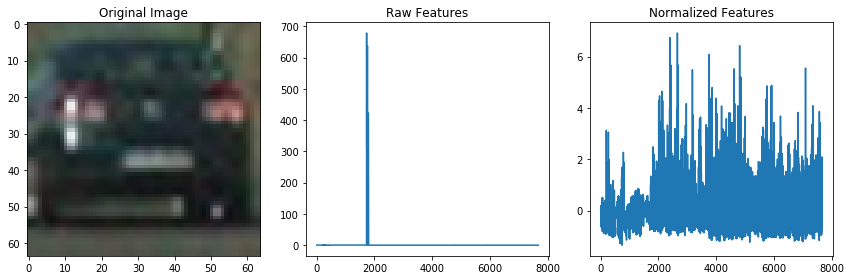

In [13]:
# Create an array stack of feature vectors

X = np.vstack((car_train_features, car_test_features,
               non_car_train_features, non_car_test_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

len1 = len(car_train_features)
len2 = len(car_test_features) + len1
len3 = len(non_car_train_features) + len2

X_train, X_test = [],[]
X_train.extend(scaled_X[:len1])
X_train.extend(scaled_X[len2:len3])
X_test.extend(scaled_X[len1:len2])
X_test.extend(scaled_X[len3:])

# Define the labels vector, 1=cars, 0=non_cars
y_train = np.hstack((np.ones(len(car_train_features)), np.zeros(len(non_car_train_features))))
y_test = np.hstack((np.ones(len(car_test_features)), np.zeros(len(non_car_test_features))))

X_train,y_train = shuffle(X_train,y_train,random_state=7)
X_test,y_test = shuffle(X_test,y_test,random_state=7)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(car_train_files[0]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[0])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[0])
plt.title('Normalized Features')
fig.tight_layout()

### 1.6 Train Classifier using Linear SVC

In [14]:
print('Using:',orient,'orientations, ',pix_per_cell, 'pixels per cell,', 
      cell_per_block,'cells per block, ', spatial_size, 'spatial_size, ',
      hist_bins, 'hist_bins.')

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of the SVC =', round(svc.score(X_test, y_test),4))

Using: 10 orientations,  8 pixels per cell, 2 cells per block,  (24, 24) spatial_size,  24 hist_bins.
Feature vector length: 7680
5.4 Seconds to train SVC...
Test Accuracy of the SVC = 0.991


## 2. Sliding Window Search

### 2.1 Functions for the Search and Visualization

In [15]:
def draw_all_windows(img, ystart, ystop, scale, pix_per_cell, cell_per_block, spatial_size, color):
    # This function was made to visualize where the sliding windows would be. 
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),color,6) 
    return draw_img

def find_cars_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #pt1, pt2 = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                bbox = [(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)]
                bboxes.append(bbox)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return bboxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from collections import deque

len_queue = 16
class BBoxes_Tracker():
    def __init__(self):
        # Most Recent BBoxes of last n images
        self.recent_bbox_lists = deque([],maxlen=len_queue)
    
    def add_bbox_list(self, bbox_list):
        self.recent_bbox_lists.append(bbox_list)
        

### 2.2  Visualizing the Windows

In [16]:
# Define the Windows
colors = [(0,0,255), (0,255,0), (255,0,0), (122,122,122), (0,0,0), (255,255,255)]
ystarts =[400,  395, 390, 385,  380]
scales = [  1, 1.25, 1.5,   2, 2.75]
nrows =  [  3,    2,   2,   1,    1]
ystops = (np.multiply(np.multiply(80, scales), (1 + np.multiply(0.25, nrows - np.ones(len(nrows))))) + ystarts).astype(int)

for i in range(len(ystarts)):
    window_size = int( 80*scales[i])
    print(nrows[i], "rows of", window_size, "x", window_size, "windows from y =", ystarts[i],":",ystops[i])
print(ystops)

3 rows of 80 x 80 windows from y = 400 : 520
2 rows of 100 x 100 windows from y = 395 : 520
2 rows of 120 x 120 windows from y = 390 : 540
1 rows of 160 x 160 windows from y = 385 : 545
1 rows of 220 x 220 windows from y = 380 : 600
[520 520 540 545 600]


In [17]:
# Hard code 
#ystops = [496,495,510,545,600]

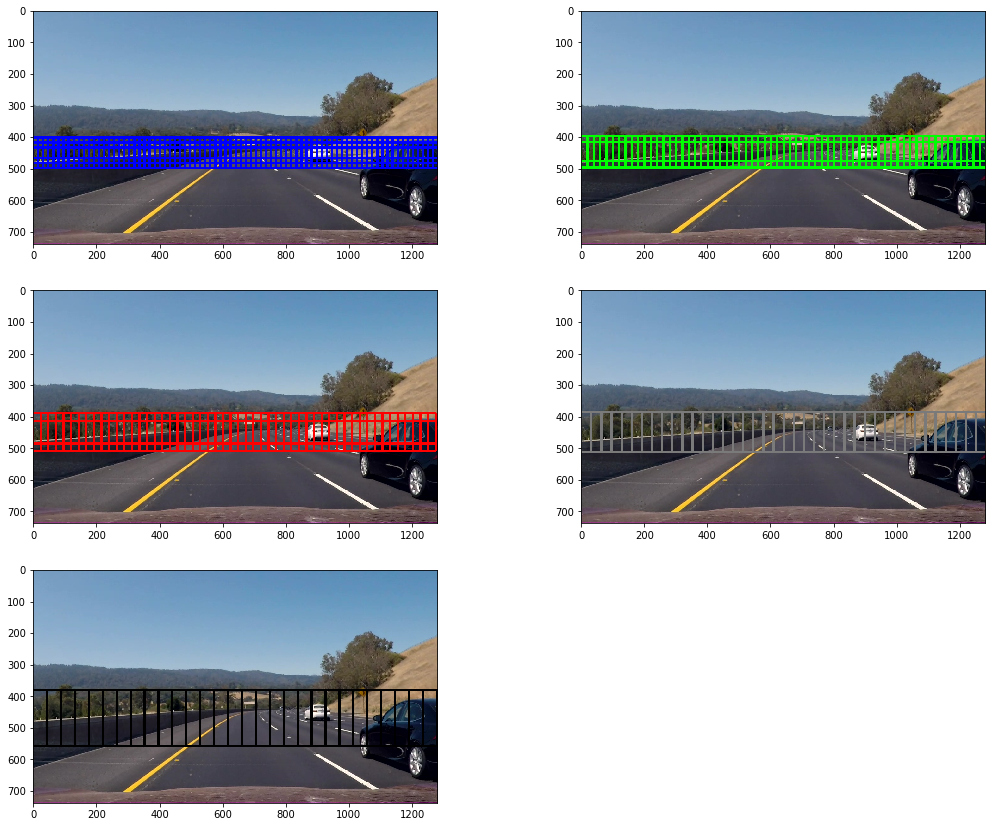

In [18]:
test_file = 'test_sequence/vlcsnap-2017-05-25-19h44m28s921.jpg'
#test_file = test_files[4]
img = mpimg.imread(test_file)

images, heatmaps = [],[]
for i in range(len(scales)):
    ystart = ystarts[i]
    ystop = ystops[i]
    scale = scales[i]
    color = colors[i]
    out_img = draw_all_windows(img, ystart, ystop, scale, pix_per_cell, cell_per_block, spatial_size, color)
    images.append(out_img)
    
fig=plt.figure(figsize=(18,30))
for i in range(len(images)):
    plt.subplot(6,2,i+1)
    plt.imshow(images[i])


### 2.3 Test Pipeline on Images

In [19]:
def pipeline(img):
    ystarts =[400,  395, 390, 385,  380]
    scales = [  1, 1.25, 1.5,   2, 2.75]
    nrows =  [  3,    2,   2,   1,    1]
    ystops = [520,  520, 540, 545,  600]
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    bbox_list = []
    for i in range(len(scales)):
        ystart = ystarts[i]
        ystop = ystops[i]
        scale = scales[i]
        bbox_list.extend(find_cars_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    bbox_tracker.add_bbox_list(bbox_list)
    for bbl in bbox_tracker.recent_bbox_lists:
        #print(bbl)
        heatmap = add_heat(heatmap, bbl)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap,26)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #images.append(draw_img)
    return draw_img, heatmap

def process_image(img):
    ystarts =[400,  395, 390, 385,  380]
    scales = [  1, 1.25, 1.5,   2, 2.75]
    nrows =  [  3,    2,   2,   1,    1]
    ystops = [520,  520, 540, 545,  600]
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    bbox_list = []
    for i in range(len(scales)):
        ystart = ystarts[i]
        ystop = ystops[i]
        scale = scales[i]
        bbox_list.extend(find_cars_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    bbox_tracker.add_bbox_list(bbox_list)
    for bbl in bbox_tracker.recent_bbox_lists:
        #print(bbl)
        heatmap = add_heat(heatmap, bbl)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap,26)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #images.append(draw_img)
    return draw_img


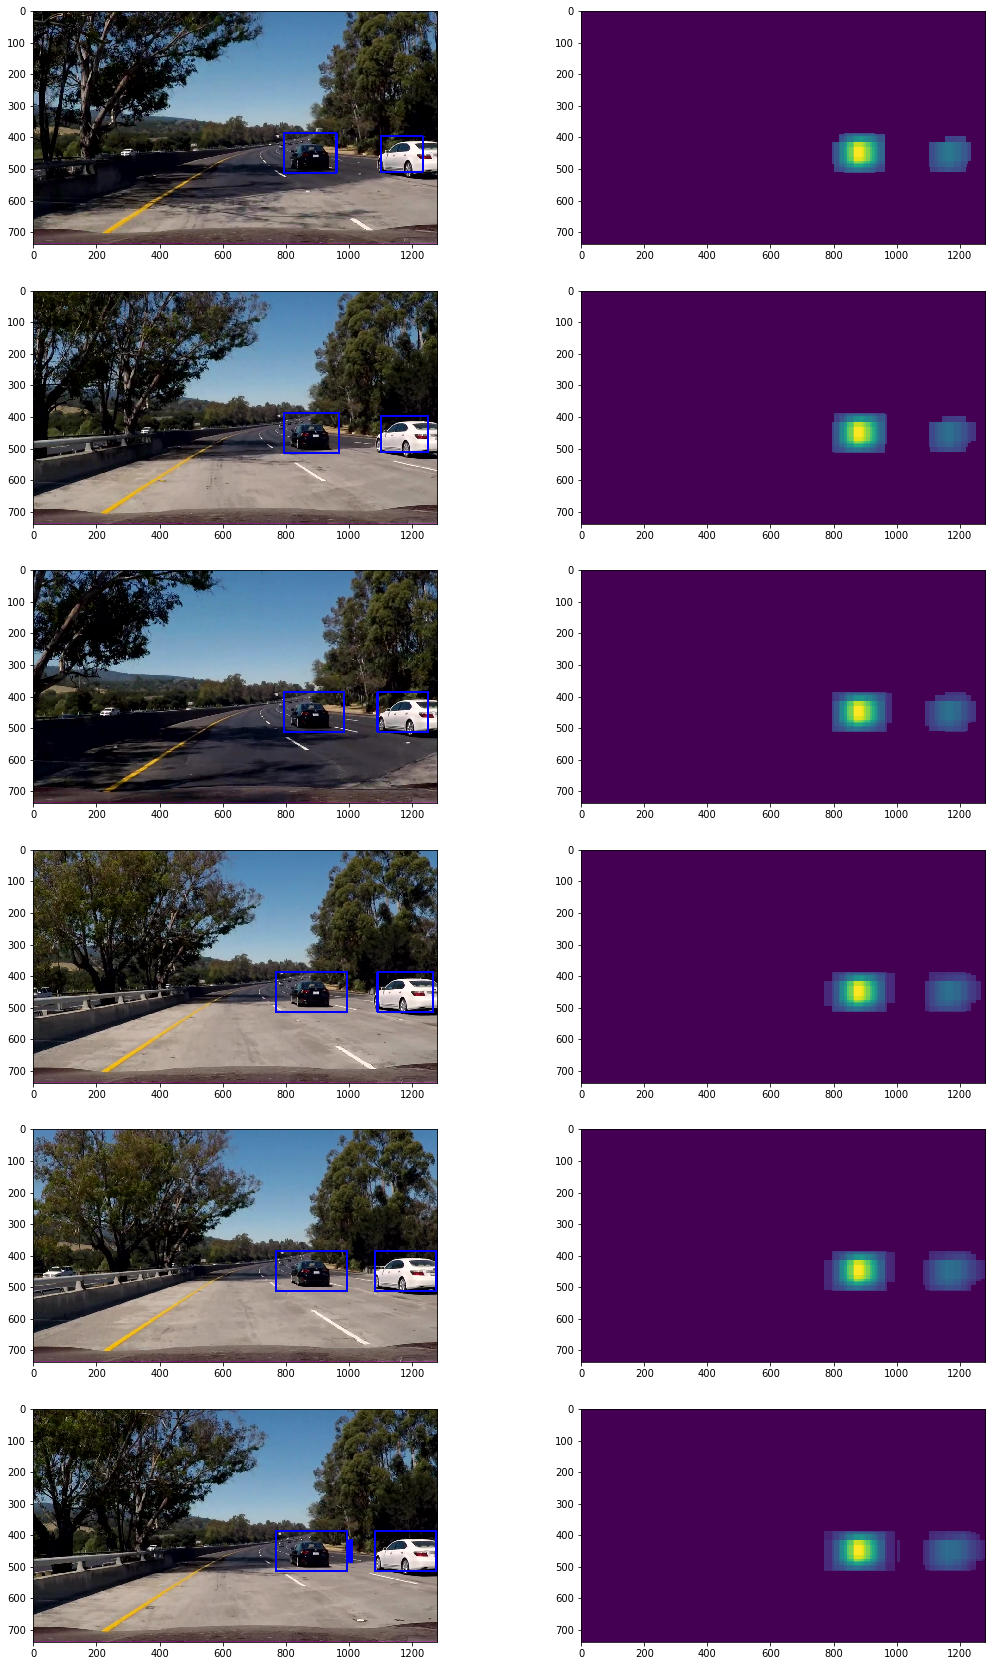

In [20]:
bbox_tracker = BBoxes_Tracker()

test_files = glob.glob('./test_sequence2/*.jpg')
#test_files = glob.glob('./test_images/*.jpg')

images, heatmaps = [],[]
for test_file in test_files:
    img = mpimg.imread(test_file)

    out_img, heatmap = pipeline(img)
    images.append(out_img)
    heatmaps.append(heatmap)
    
fig=plt.figure(figsize=(18,30))
## Ignore first 4 to let the heatmap accumulate. 
for i in range(0,len(images)-4):
    plt.subplot(len(images)-4,2,i*2+1)
    plt.imshow(images[i+4])
    plt.subplot(len(images)-4,2,i*2+2)
    plt.imshow(heatmaps[i+4])

In [22]:
bbox_tracker = BBoxes_Tracker()
video_savefile = 'output_videos/test_output.mp4'
#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("test_videos/project_video.mp4")


video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_savefile, audio=False)

[MoviePy] >>>> Building video output_videos/test_output.mp4
[MoviePy] Writing video output_videos/test_output.mp4


100%|█████████▉| 1260/1261 [12:11<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_output.mp4 

CPU times: user 12min 39s, sys: 1.96 s, total: 12min 40s
Wall time: 12min 12s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_savefile))